### **Importing Libraries** <a id="head1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
                                                                                   
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import pickle

import warnings
warnings.filterwarnings('ignore')

### **Loading Data** <a id="head2"></a>

In [2]:
telco_customer = pd.read_csv("ChurnTrainDataset.csv")

In [3]:
telco_customer

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107.0,area_code_415,no,yes,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,no
1,NJ,137.0,area_code_415,no,no,0.0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,no
2,OH,84.0,area_code_408,yes,no,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,no
3,OK,75.0,area_code_415,yes,no,0.0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,no
4,MA,121.0,area_code_510,no,yes,24.0,218.2,88.0,37.09,348.5,108.0,29.62,212.6,118.0,9.57,7.5,7.0,2.03,3.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83.0,area_code_415,no,no,0.0,188.3,70.0,32.01,243.8,88.0,20.72,213.7,79.0,9.62,10.3,6.0,2.78,0.0,no
4246,WV,73.0,area_code_408,no,no,0.0,177.9,89.0,30.24,131.2,82.0,11.15,186.2,89.0,8.38,11.5,6.0,3.11,3.0,no
4247,NC,75.0,area_code_408,no,no,0.0,170.7,101.0,29.02,193.1,126.0,16.41,129.1,104.0,5.81,6.9,7.0,1.86,1.0,no
4248,HI,50.0,area_code_408,no,yes,40.0,235.7,127.0,40.07,223.0,126.0,18.96,297.5,116.0,13.39,9.9,5.0,2.67,2.0,no


### **Preprocessing** <a id="head5"></a>

In [4]:
# Encoding categorical data using cat codes
for col in telco_customer.columns[telco_customer.dtypes == 'object']:
    if col!='churn':
        telco_customer[col]=telco_customer[col].astype('category').cat.codes

# Fill Null Values of target column
telco_customer['churn'] =  telco_customer['churn'].fillna(telco_customer['churn'].mode()[0])

# Manual encoding the target variable
a={'yes':1,'no':0}
telco_customer['churn']=telco_customer['churn'].map(a)

### **Seperate Features & Target Variable** <a id="head6"></a>

In [5]:
X = telco_customer.drop('churn',axis=1)
y=telco_customer['churn']

In [6]:
cat_cols = X.select_dtypes(include=['int8']).columns.values

In [7]:
num_cols = X.select_dtypes(include=['float64']).columns.values

### **Train Test Split**  <a id="head7"></a>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

## Feature Engineering pipeline

In [9]:
# Imputation Transformer to fill null values
fill_null_col = ColumnTransformer([
        ('FillCat',SimpleImputer(strategy='most_frequent'),cat_cols),
        ('FillNumeric',SimpleImputer(strategy='median'),num_cols),
    ],remainder='passthrough')

# Scaling
scale_col = ColumnTransformer([
    ('scale', StandardScaler(),slice(5,18))
])

# Principal Component Analysis
pca_col = ColumnTransformer([
    ('PCA', PCA(n_components=10),slice(0,18))
])

# # Model
logistic=LogisticRegression()
random = RandomForestClassifier()
svm=SVC(kernel ='rbf',probability=True)

### **Model Pipeline** <a id="head9"></a>

In [10]:
pipeline_model1 = Pipeline([('fill_null_col', fill_null_col),
                 ('scale_col', scale_col),
                 ('pca_col', pca_col),
                 ('classifier1', logistic)])

pipeline_model2 = Pipeline([('fill_null_col', fill_null_col),
                 ('scale_col', scale_col),
                 ('pca_col', pca_col),
                 ('classifier2', random)])

pipeline_model3 = Pipeline([('fill_null_col', fill_null_col),
                 ('scale_col', scale_col),
                 ('pca_col', pca_col),
                 ('classifier3', svm)])

In [11]:
pipelines=[pipeline_model1,pipeline_model2,pipeline_model3]

In [12]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [13]:
pipe_dict={0:'Logistic Regression',1:'Random Forest',2:'SVM'}

# Fitting pipelines
for pipe in pipelines:
    pipe.fit(X_train,y_train)

In [14]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy : {}".format(pipe_dict[i],model.score(X_test,y_test)))

Logistic Regression Test Accuracy : 0.8552941176470589
Random Forest Test Accuracy : 0.8776470588235294
SVM Test Accuracy : 0.8917647058823529


In [15]:
for i,model in enumerate(pipelines):
    pred=model.predict(X_test)
    print("\n{} Confusion Matrix :\n {}".format(pipe_dict[i],confusion_matrix(y_test, pred)))
    print("\n{} Classification Report :\n {}".format(pipe_dict[i],classification_report(y_test,pred)))


Logistic Regression Confusion Matrix :
 [[724   0]
 [123   3]]

Logistic Regression Classification Report :
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       724
           1       1.00      0.02      0.05       126

    accuracy                           0.86       850
   macro avg       0.93      0.51      0.48       850
weighted avg       0.88      0.86      0.79       850


Random Forest Confusion Matrix :
 [[717   7]
 [ 97  29]]

Random Forest Classification Report :
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       724
           1       0.81      0.23      0.36       126

    accuracy                           0.88       850
   macro avg       0.84      0.61      0.65       850
weighted avg       0.87      0.88      0.85       850


SVM Confusion Matrix :
 [[720   4]
 [ 88  38]]

SVM Classification Report :
               precision    recall  f1-score   support

     

### Precision Recall Curve of all models

In [16]:
def precision_recall_curve_plots(p,r,n,y_test):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(r, p, label=n)
    baseline = len(y_test[y_test==1]) / len(y_test)
    ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc='center left');

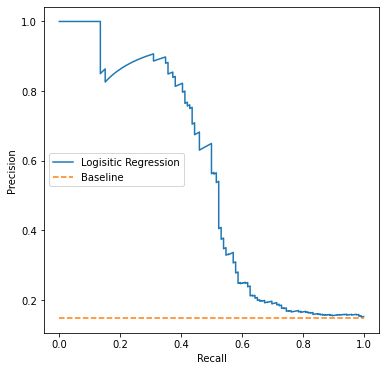

In [17]:
# Precision Recall Curve For Logistic Regression
probs = pipeline_model1.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
name="Logisitic Regression"
precision_recall_curve_plots(precision,recall,name,y_test)

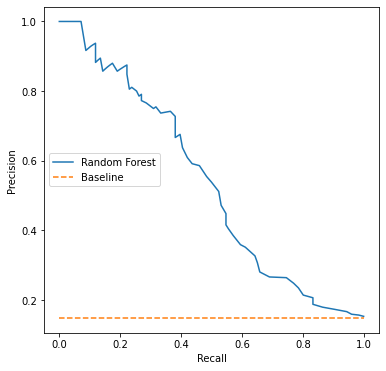

In [18]:
# Precision Recall Curve For Random Forest
probs = pipeline_model2.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
name="Random Forest"
precision_recall_curve_plots(precision,recall,name,y_test)

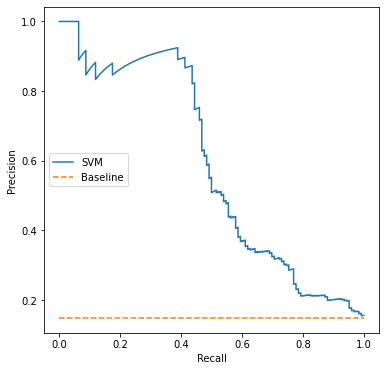

In [19]:
# Precision Recall Curve For SVM
probs = pipeline_model3.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
name="SVM"
precision_recall_curve_plots(precision,recall,name,y_test)

### ROC Curve

In [20]:
probs = pipeline_model1.predict_proba(X_test)[:, 1]
fpr1, tpr1, thresh1 = roc_curve(y_test, probs)

In [21]:
probs = pipeline_model2.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresh2 = roc_curve(y_test, probs)

In [22]:
probs = pipeline_model3.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresh3 = roc_curve(y_test, probs)

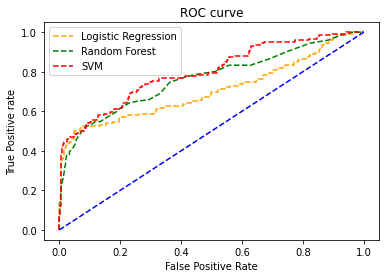

In [23]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

 # plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Random Forest')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

In [24]:
for i,model in enumerate(pipelines):
    if model.score(X_test,y_test)>best_accuracy:
        best_accuracy=model.score(X_test,y_test)
        best_pipeline=model
        best_classifier=i
print('Classifier with the best accuracy:{}'.format(pipe_dict[best_classifier]))

Classifier with the best accuracy:SVM


### **Best Hyperparameters for Models Using GridSearchCV using a pipeline** 
<a id="head10"></a>

In [25]:
params = [{ 'classifier1__solver' : ['newton-cg', 'lbfgs', 'liblinear'],
            'classifier1__penalty': ['l2','l1'] ,
            'classifier1__C' :np.logspace(-4,4,20),
          }]
hypertuned_model1 = GridSearchCV(estimator = pipeline_model1,
                           param_grid = params,
                           cv = 10 ,verbose = 1, n_jobs=-1)

hypertuned_model1.fit(X_train,y_train)
hypertuned_model1.best_params_

In [26]:
randomized_cv1 = Pipeline([('fill_null_col', fill_null_col),
                 ('scale_col', scale_col),
                 ('pca_col', pca_col),
                 ('classifier1', LogisticRegression(solver='liblinear',penalty='l2',C=0.0001))])

randomized_cv1.fit(X_train,y_train)

Pipeline(steps=[('fill_null_col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('FillCat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  array(['state', 'area_code', 'international_plan', 'voice_mail_plan'],
      dtype=object)),
                                                 ('FillNumeric',
                                                  SimpleImputer(strategy='median'),
                                                  array(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_c...
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'], dtype=object))])),
                ('scale_col',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                               

In [27]:
params = [{"classifier2__n_estimators": range(100, 501, 100),
           "classifier2__max_depth":range(10,30,10),
           "classifier2__min_samples_leaf":[1, 2, 4],
           "classifier2__min_samples_split": [2, 5, 10],
          }]
                 
hypertuned_model2 = GridSearchCV(estimator = pipeline_model2,
                           param_grid = params,
                           cv = 10 ,verbose = 1, n_jobs=-1)

hypertuned_model2.fit(X_train,y_train)
hypertuned_model2.best_params_

In [28]:
randomized_cv2= Pipeline([('fill_null_col', fill_null_col),
                 ('scale_col', scale_col),
                 ('pca_col', pca_col),
                 ('classifier2', RandomForestClassifier(max_depth=20,min_samples_leaf=1,min_samples_split=5,n_estimators=400,class_weight='balanced'))])

randomized_cv2.fit(X_train,y_train)

Pipeline(steps=[('fill_null_col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('FillCat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  array(['state', 'area_code', 'international_plan', 'voice_mail_plan'],
      dtype=object)),
                                                 ('FillNumeric',
                                                  SimpleImputer(strategy='median'),
                                                  array(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_c...
       'number_customer_service_calls'], dtype=object))])),
                ('scale_col',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  slice(5, 18, None))])),
                ('pca_col',
                 ColumnTransformer(transformers=[

In [29]:
params = [{ 'classifier3__C' : [1, 10, 100, 1000],
          'classifier3__gamma': [1e-1, 1e-4] }]

hypertuned_model3 = GridSearchCV(estimator = pipeline_model3,
                           param_grid = params,
                           cv = 10 ,verbose = 1, n_jobs=-1)

hypertuned_model3.fit(X_train,y_train)
hypertuned_model3.best_params_

In [30]:
randomized_cv3 = Pipeline([('fill_null_col', fill_null_col),
                 ('scale_col', scale_col),
                 ('pca_col', pca_col),
                 ('classifier3', SVC(kernel ='rbf',probability=True,C=1,gamma=0.1))])

randomized_cv3.fit(X_train,y_train)

Pipeline(steps=[('fill_null_col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('FillCat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  array(['state', 'area_code', 'international_plan', 'voice_mail_plan'],
      dtype=object)),
                                                 ('FillNumeric',
                                                  SimpleImputer(strategy='median'),
                                                  array(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_c...
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'], dtype=object))])),
                ('scale_col',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                               

In [31]:
loaded_model1=randomized_cv1
loaded_model2=randomized_cv2

### Saving SVM Model

In [32]:
filename = 'modelv2.pkl'
pickle.dump(randomized_cv3, open(filename, 'wb'))


### Load the model from disk

In [33]:
filename = 'modelv2.pkl'
loaded_model3 = pickle.load(open(filename, 'rb'))
result = loaded_model3.score(X_test, y_test)
print(result)

0.8941176470588236


### Model Prediction After Hypertuning

In [34]:
def model_predict(loaded_model,X_test,y_test):
    y_pred_proba = loaded_model.predict_proba(X_test)
    y_pred= loaded_model.predict(X_test)
    print("Predcition Probability\n\n",y_pred_proba)
    print("\nPredcition\n\n",y_pred)
    acc = accuracy_score(y_test, y_pred)
    print("\nAccuracy=",acc)
    print("\nClassification Report\n\n",classification_report(y_test,y_pred))
    print("\nConfusion Matrix\n",confusion_matrix(y_test, y_pred))

In [35]:
# Logistic Regression
model_predict(loaded_model1,X_test,y_test)

Predcition Probability

 [[0.53279674 0.46720326]
 [0.52784266 0.47215734]
 [0.52209455 0.47790545]
 ...
 [0.51402911 0.48597089]
 [0.54563261 0.45436739]
 [0.51896569 0.48103431]]

Predcition

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [36]:
# Random Forest
model_predict(loaded_model2,X_test,y_test)

Predcition Probability

 [[0.96123599 0.03876401]
 [0.88229601 0.11770399]
 [0.85031983 0.14968017]
 ...
 [0.760305   0.239695  ]
 [0.8863537  0.1136463 ]
 [0.89670761 0.10329239]]

Predcition

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [37]:
# SVM
model_predict(loaded_model3,X_test,y_test)

Predcition Probability

 [[0.97274449 0.02725551]
 [0.90641831 0.09358169]
 [0.86145532 0.13854468]
 ...
 [0.71868949 0.28131051]
 [0.89989547 0.10010453]
 [0.9081071  0.0918929 ]]

Predcition

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### **Model Prediction After Thresholding**<a id="head11"></a>

In [38]:
def model_predict_with_threshold(loaded_model,X_test,threshold,y_test):
    y_pred_proba = loaded_model.predict_proba(X_test)
    y_pred= (loaded_model.predict_proba(X_test)[:,1] >= threshold).astype(int)
    print("Predcition Probability\n\n",y_pred_proba)
    print("\nPredcition\n\n",y_pred)
    acc = accuracy_score(y_test, y_pred)
    print("\nAccuracy=",acc)
    print("\nClassification Report\n\n",classification_report(y_test,y_pred))
    print("\nConfusion Matrix\n",confusion_matrix(y_test, y_pred))

In [39]:
# Logistic Regression

In [40]:
pred = loaded_model1.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, pred)
fscore = (2 * precision * recall) / (precision + recall)

In [41]:
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

Best Threshold: 0.488 with F-Score: 0.5619


In [42]:
model_predict_with_threshold(loaded_model1,X_test,thresholdOpt,y_test)

Predcition Probability

 [[0.53279674 0.46720326]
 [0.52784266 0.47215734]
 [0.52209455 0.47790545]
 ...
 [0.51402911 0.48597089]
 [0.54563261 0.45436739]
 [0.51896569 0.48103431]]

Predcition

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 

In [43]:
# Random Forest

In [44]:
pred = loaded_model2.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, pred)
fscore = (2 * precision * recall) / (precision + recall)

In [45]:
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

Best Threshold: 0.2806 with F-Score: 0.5634


In [46]:
model_predict_with_threshold(loaded_model2,X_test,thresholdOpt,y_test)

Predcition Probability

 [[0.96123599 0.03876401]
 [0.88229601 0.11770399]
 [0.85031983 0.14968017]
 ...
 [0.760305   0.239695  ]
 [0.8863537  0.1136463 ]
 [0.89670761 0.10329239]]

Predcition

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [47]:
# SVM

In [48]:
pred = loaded_model3.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, pred)
fscore = (2 * precision * recall) / (precision + recall)

In [49]:
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

Best Threshold: 0.4231 with F-Score: 0.5851


In [50]:
model_predict_with_threshold(loaded_model3,X_test,thresholdOpt,y_test)

Predcition Probability

 [[0.97274449 0.02725551]
 [0.90641831 0.09358169]
 [0.86145532 0.13854468]
 ...
 [0.71868949 0.28131051]
 [0.89989547 0.10010453]
 [0.9081071  0.0918929 ]]

Predcition

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 